# Modeling and Simulation in Python

Chapter 6: Analysis

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Code from the previous chapter

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [2]:
def make_system(beta1, gamma1, beta2, gamma2, t_b):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init1 = State(S=89, I1=1, R1=0, I2=0, R2=0, Iboth=0, I12=0, I21=0, Rboth=0)
    seriesS = TimeSeries()
    seriesI = TimeSeries()
    seriesR = TimeSeries()
    #S: num people who didn't get either disease
    #I1: num people who are infected by disease A
    #R1: num people who recovered from disease A
    #I2: num people who are infected by disease B
    #R2: num people who recovered from disease B
    #Iboth: num people infected by both diseases
    #I12: num people recovered from disease A and got disease B
    #I21: num people recovered from disease B and got disease A
    #Rboth: num people who recovered from both diseases
    #seriesS: total num people susceptible 
    #seriesI: total num people infected
    #seriesR: total num people who recovered 
    
    init1 /= np.sum(init1)

    t0 = 0
    t_end = 7 * 14 *2
    t_b = t_b
    print(t_b)

    return System(init1=init1, t0=t0, t_end=t_end, t_b = t_b, seriesS=seriesS, seriesI=seriesI, seriesR=seriesR,
                  beta1=beta1, gamma1=gamma1, beta2=beta2, gamma2=gamma2)

In [17]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    return system.seriesS[system.t0] - system.seriesS[system.t_end]

In [4]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's an updated version of `run_simulation` that uses `unpack`.

In [5]:
def run_simulation(system):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init1.index)
    frame.loc[t0] = init1
    seriesS[t0] = init1.S
    seriesI[t0] = init1.I1
    seriesR[t0] = init1.R1
    
    for i in linrange(t0, t_end):
        if i < t_b:
            frame.loc[i+1] = update1(frame.loc[i], system, i)
        else:
            frame.loc[i+1] = update2(frame.loc[i], system, i)
    
    system.results = frame

In [6]:
def update1(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i1, r1, i2, r2, iboth, i12, i21, rboth = state

    infected = beta1 * i1 * s    
    recovered = gamma1 * i1
    
    s -= infected
    i1 += infected - recovered
    r1 += recovered
    
    seriesS[i] = s
    seriesI[i] = i1 + i2 + iboth + i12 + i21
    seriesR[i] = r1 + r2 + rboth
    
    return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)

In [39]:
def update2(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i1, r1, i2, r2, iboth, i12, i21, rboth = state
    
#     beta1offset1 = beta1 + beta1/100
#     beta1offset2 = beta1 - beta1/100
#     beta2offset1 = beta2 + beta2/100
#     beta2offset2 = beta2 - beta2/100
    
#     gamma1offset1 = gamma1 + gamma1/100
#     gamma1offset2 = gamma1 - gamma1/100
#     gamma2offset1 = gamma2 + gamma2/100
#     gamma2offset2 = gamma2 - gamma2/100
    
    beta1offset1 = beta1
    beta1offset2 = beta1
    beta2offset1 = beta2
    beta2offset2 = beta2
    
    gamma1offset1 = gamma1 
    gamma1offset2 = gamma1 
    gamma2offset1 = gamma2
    gamma2offset2 = gamma2 
    
    if i2 == 0:
        i2 = 10/90
        s = s - i2
    
    s = s - ((beta1*s*i1) - (beta2*s*i2))
    i1 = i1 + ((beta1*s*i1) - (gamma1*i1))
    i1 = i1 - (beta2offset1*i1*i2)
    i2 = i2 + ((beta2*s*i2) - (gamma2*i2))
    i2 = i2 - (beta1offset1*i1*i2)
    
    iboth = iboth + (((beta2offset1*i1*i2) + (beta1offset1*i1*i2)) - ((1/((1/gamma1)+(1/gamma2)))*iboth))
    
    r1 = r1 + (gamma1*i1) - ((beta2offset2*r1*(i2+iboth)))
    r2 = r2 + (gamma2*i2) - ((beta1offset2*r2*(i1+iboth)))
    
    i12 = i12 + ((beta2offset2*r1*(i2+iboth)) - (gamma2offset1*i12))
    i21 = i21 + ((beta1offset2*r2*(i1+iboth)) - (gamma1offset1*i21))
    
    rboth = rboth + (gamma2offset1*i12) + (gamma1offset1*i21) + ((1/((1/gamma1)+(1/gamma2)))*iboth)
    
    
    seriesS[i] = s + r1 + r2
    seriesI[i] = i1 + i2 + iboth + i12 + i21
    seriesR[i] = rboth
    
    #if seriesS[i] + seriesI[i] + seriesR[i] != 1:
       # print("something is wrong at ", i)
       # print(seriesS[i] + seriesI[i] + seriesR[i])
        
    return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)

Test the updated code with this example.

In [40]:
tc1 = 3
tr1 = 6
tc2 = 2
tr2 = 8
beta1 = 1 / tc1
gamma1 = 1 / tr1
beta2 = 1 / tc2
gamma2 = 1 / tr2
system = make_system(beta1, gamma1, beta2, gamma2, 30)
run_simulation(system)
system.results = system.results.dropna()
print(system.results)

30


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars


               S            I1            R1            I2            R2  \
0   9.888889e-01  1.111111e-02  0.000000e+00  0.000000e+00  0.000000e+00   
1   9.852263e-01  1.292181e-02  1.851852e-03  0.000000e+00  0.000000e+00   
2   9.809827e-01  1.501181e-02  4.005487e-03  0.000000e+00  0.000000e+00   
3   9.760739e-01  1.741862e-02  6.507456e-03  0.000000e+00  0.000000e+00   
4   9.704066e-01  2.018280e-02  9.410559e-03  0.000000e+00  0.000000e+00   
5   9.638781e-01  2.334751e-02  1.277436e-02  0.000000e+00  0.000000e+00   
6   9.563767e-01  2.695764e-02  1.666561e-02  0.000000e+00  0.000000e+00   
7   9.477829e-01  3.105859e-02  2.115855e-02  0.000000e+00  0.000000e+00   
8   9.379706e-01  3.569443e-02  2.633498e-02  0.000000e+00  0.000000e+00   
9   9.268105e-01  4.090546e-02  3.228405e-02  0.000000e+00  0.000000e+00   
10  9.141733e-01  4.672509e-02  3.910163e-02  0.000000e+00  0.000000e+00   
11  8.999350e-01  5.317585e-02  4.688915e-02  0.000000e+00  0.000000e+00   
12  8.839834

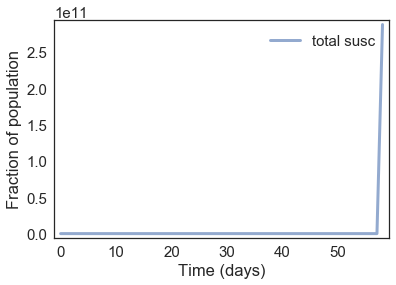

In [35]:
frame = system.results
plot(frame.S, label='total susc')
# plot(frame.R1, label='recovered from only a')
# plot(frame.R2, label='recovered from only b')
# plot(frame.Rboth, label="recovered from b and a")
decorate(xlabel='Time (days)',
             ylabel='Fraction of population')
#plot_results(system.seriesS, system.seriesI, system.seriesR)

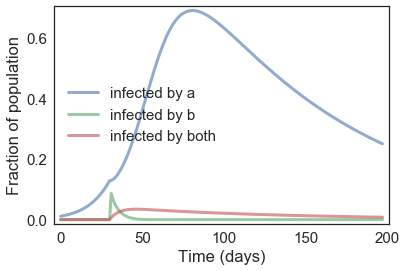

In [10]:
plot(frame.I1, label='infected by a')
plot(frame.I2, label='infected by b')
plot(frame.Iboth, label='infected by both')
decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [22]:
beta2_array = linspace(0.1, 0.9, 11)

def sweep_beta(beta_array):
    """SweepSeriess a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta2 in beta_array:
        system = make_system(0.1, 0.01, beta2, 0.6, 30)
        run_simulation(system)
        plot(frame.S, label='total susc')
        plot(frame.R1, label='recovered from only a')
        plot(frame.R2, label='recovered from only b')
        plot(frame.Rboth, label="recovered from b and a")
        decorate(xlabel='Time (days)',
                     ylabel='Fraction of population')
        sweep[system.beta1] = calc_total_infected(system)
    return sweep

30
30
30
30
30
30
30
30


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encou

30


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


30


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars


30


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars


,value
0.1,NaN


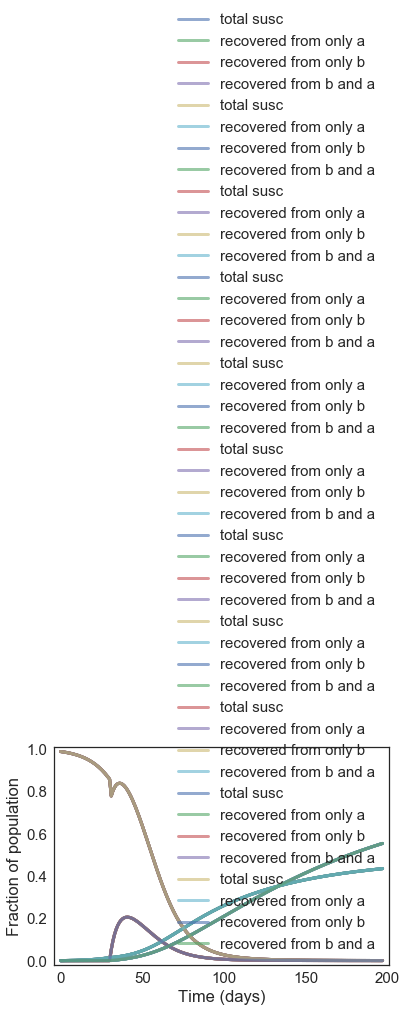

In [23]:
sweep_beta(beta2_array)

In [27]:
gamma1_array = linspace(0.1, 0.9, 11)

def sweep_gamma(gamma_array):
    """SweepSeriess a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for gamma1 in gamma_array:
        system = make_system(0.1, gamma1, 0.5, 0.6, 30)
        run_simulation(system)
        plot(frame.S, label='total susc')
        plot(frame.R1, label='recovered from only a')
        plot(frame.R2, label='recovered from only b')
        plot(frame.Rboth, label="recovered from b and a")
        decorate(xlabel='Time (days)',
                     ylabel='Fraction of population')
        sweep[system.gamma1] = calc_total_infected(system)
    return sweep

30


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


30


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountere

30


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


30
30
30
30
30
30
30
30


,value
0.10,NaN
0.18,NaN
0.26,NaN
0.34,NaN
0.42,NaN
0.50,NaN
0.58,NaN
0.66,NaN
0.74,NaN
0.82,NaN


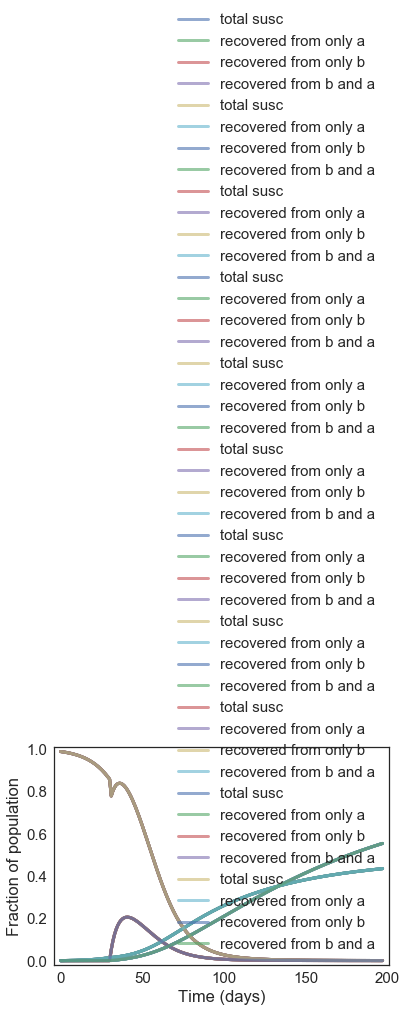

In [28]:
sweep_gamma(gamma1_array)